In [2]:
#purpose is to generate images in the steps below, first collecting some files
'''
Paths and file needs:
*imglams and spitzer_conversions are excel files, right now I have it so you need to put it as same directory as your code (but could later maybe just give it a path to go to - would be smarter)
*paths to images and data in general
'''
#now the steps
'''
1) read in all the data by noting all the paths to given spitzer and hubble images
2) loop through all the data, read it in, convert units
3) cutout all the data as appropriate
3) create a loop or otherwise hardcode going through all the combinations of convolutions of images by hand...
4) regrid all the images
5) de-extinct all the images
6) create apertures as appropriate for all the knots
7) perform relevant analyses: e.g. taking ratio and then finding EDFs, summing up the intensities of each knot for noting and saving
'''

#just to check python version - should be 3.7.4
from platform import python_version
print(python_version())

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from reproject import reproject_exact  #a package that can be added to astropy using anaconda or pip (see their docs pg)
from reproject import reproject_interp

import glob
import itertools
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys


#this part is unnecessary...in jupyter...point was to test blocks of code
#switches for the three different parts of this code
# switch1 = 'on' #convolving images [needed to put it on for switch 3 at min...need to figure out other solution, eh]
# switch1b = 'on' #regridding...
# switch2 = 'on' #solving equations
# switch3 = 'on' #plotting / graphics of solutions

3.8.5


In [3]:
# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names


# In[5]:

'''now convolve my image with a PSF of the image we're projecting ONTO
an approx PSF can be found by assuming a 2D Gaussian func with a width (a FWHM) of the diffrac limit
that is the st dev of the Gaussian is about the st dev is about = lambda/D
a list of PSFs are found on https://docs.astropy.org/en/stable/convolution/kernels.html

Notes:
FIRST: always must convert hdu1_pixtorad to radians! It's inconsistent otherwise, and lambda/D is generally in radians

what we're using for the gaussian width is the FWHM, not the radius of the first ring of the diffraction pattern,
so it's 1.2 not 1.22 times lambda/D

D is 85 cm for spitzer
D is 2.4 m for hubble
'''

def im_conv(low_res_name, D, hdu_pix_torad, hdu_dat, kern):
    #unfortuantely no good way to find wavelength from header right now. can enter it manually, but I tried to automate it

    #reading in excel file of wavelengths...right now needs to be in same directory as this code
    #first col is a substring of the fits image file name, the second col is the wavelengths in microns
    df = pd.read_excel('imglams.xlsx')
    cols = df.columns
    cols_str = [str(i) for i in df[cols[0]]]
    #some test cases I was using

    #gaussian kernel
    if kern == 'gauss':
        #this finds the loc in the excel file where the image substring matches our image name
        #it then finds the wavelength value corresponding to that loc
        lam =  df.loc[np.where([i in low_res_name for i in cols_str])[0][0]].values[1] #lambda in microns

        #finding angular resolution...the FWHM of our Gaussian PSF
        res = 1.2 * lam / D         #resolution in radians
        res = res / hdu_pix_torad        #so converting to pixels

        #finding PSF and then calculating the convolution of our image and the PSF of the image we're projecting onto
        kernel = Gaussian2DKernel(res)

    #box kernel
    if kern == 'box':
        kernel = Box2DKernel(16.)

    hdu_conv = convolve(hdu_dat, kernel)
    return hdu_conv



# In[27]:

#setting up a new fits file to be saved and viewed in DS9
#primarily to save the image we reprojected, but can also be used to save the convolved images
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])

    #saving the file
    new_filename = name.split('/')[-1]  #grabs the file name we were using from before
    hdul.writeto(save_path+new_filename, overwrite=True)

    return (save_path+new_filename)

In [5]:
# In[28]:
#trying it automatically
# path = '../../../ngc1333_fits/'
# im_names_hub_dash = im_name_finder(path+'*', 'fit')
# im_names_hub_dash = [i.replace('\\', '/') for i in im_names_hub_dash]
# im_names_hub = [path+'126_image.fits', path+'128_image.fits', path+'164_image.fits', path+'672_image.fits',
#                 path+'halph_hart_image.fits']

#this time setting up the file names by hand since I've found that easier...
#order: halpha or .656 mic, 0.672 mic, 1.26, 1.28, 1.64
# files_units = ['../../../../ngc1333_fits/unregridded/656_image.fits', 
#                '../../../../ngc1333_fits/unregridded/0301_flt.fits', 
#                '../../../../ngc1333_fits/unregridded/0501_flt.fits', 
#                '../../../../ngc1333_fits/126build_shift_2_drz.fits', 
#                '../../../../ngc1333_fits/128build_shift_2_drz.fits', 
#                '../../../../ngc1333_fits/164build_shift_2_drz.fits']
# hdu_list_units = [fits.open(i) for i in files_units]
# files_data = ['../../../../ngc1333_fits/656_hareproject.fits', 
#               '../../../../ngc1333_fits/0301_oIreproject2.fits', 
#               '../../../../ngc1333_fits/672_sIIreproject.fits', 
#               '../../../../ngc1333_fits/Background_corr/background_corr_126_aligned.fits', 
#               '../../../../ngc1333_fits/Background_corr/background_corr_128_aligned.fits', 
#               '../../../../ngc1333_fits/Background_corr/background_corr_164_aligned.fits']
# hdu_list = [fits.open(i) for i in files_data]

# #EX: grabbing all the fits image paths in a directory, #so they can be looped through and their data opened
# #set your path to some directory with images # (the images can be in subdirectories)
#the spitzer images
path = '../../../n1333_photometry_ds9.bck.dir/**' # #using ** will grab all files even in subdirectories WARNING takes longer
im_names_spitz = im_name_finder(path, 'fit') #im_finder is basically glob.glob
im_names_spitz = [i.replace('\\', '/') for i in im_names_spitz]

#the hubble images
files_units = ['../../../ngc1333_fits/126build_shift_2_drz.fits', 
                '../../../ngc1333_fits/128build_shift_2_drz.fits', 
                '../../../ngc1333_fits/164build_shift_2_drz.fits']

files_data = ['../../../ngc1333_fits/126build_shift_2_drz.fits', 
                '../../../ngc1333_fits/128build_shift_2_drz.fits', 
                '../../../ngc1333_fits/164build_shift_2_drz.fits']

#initializing some lists to be used
hdu_pix_list = []
hdu_pixtorad_list = []
hdu_fnu_list = []
hdu_flam_list = []
hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []
# throughput_list = [1., 1., 1., 1., 1., 1.] # [0.242, 1., 0.246, 0.496, 0.521, 0.470] #also has to be done by hand, not in the headers?



#next we'd want to just grab data, but first we have to figure out what spitzer images actually have calscales available
#note: we don't need to do this for hubble b/c those units are all avail!
df_spitz = pd.read_excel('spitzer_bandwidths_calscale.xlsx') #reading in excel file of bandwidths
cols_spitz = df_spitz.columns #first col is a substring of the fits image file name, the second col is the bandwidth / calscale
cols_spitz_str = [str(i) for i in df_spitz[cols_spitz[0]]]

spitz_with_bw = [] #will be a list of spitzer image paths that also have bandwidths avail
spitz_bw_conversion = [] #the actual conversion factor bandwidth / calscale

#looping through spitzer file names
for image_name in im_names_spitz:
    split_name = image_name.split('/')[-1] #splits name at "FrameN/" and picks last element (file name)
        
    #the try accept checks if avail, if it is we append to our list of images we'll use
    try: 
#         print(df.loc[np.where([i in split_name for i in cols_spitz_str])[0][0]])
        bw_spitz =  df_spitz.loc[np.where([i in split_name for i in cols_spitz_str])[0][0]].values[1] #bandwidth/calscale
        spitz_with_bw.append(image_name)
        spitz_bw_conversion.append(bw_spitz)
        
    #if not, then we note the image name for later but don't append it
    except:
        print('failed to find bandwidth/calscale: ', image_name)

#combining lists and initializing empty lists for future use
files_units = spitz_with_bw + files_units
files_data = spitz_with_bw + files_data

#opening data and headers
hdu_list_units = [fits.open(i) for i in files_units]
hdu_list = [fits.open(i) for i in files_data]



    
#I'm using count here just to point to specific indices that I've set up...unfortunately some have different headers...
#the only diff between the if and else cases are the indexing of the hdu's, some need 1 and some need 0
#I've tried to group it for convience, so the the first two have the same headers, the last 3 have the same headers
count = 0
for (hdu_units,hdu_data) in zip(hdu_list_units, hdu_list):
    if count < len(hdu_list)-3: #the spitzer ones
        #reading in conversions
        hdu_pix_list.append(hdu_units[0].header['CDELT2'])  #CDELT2 is the keyword for Spitzer images, in arcsec
        hdu_pixtorad_list.append(hdu_pix_list[count] * np.pi / 180.) #convert to radians
        # hdu_fnu_list.append(hdu_units[0].header['PHOTFNU'])
        # hdu_flam_list.append(hdu_units[0].header['PHOTFLAM'])
#         hdu_bw_list.append(hdu_units[0].header['PHOTBW'])

        #reading in datafor general use  and header for wcs
        #the spiter data is in MJy / sr, so let's convert out the MJy to Flam units, times by bw/calscale from earlier
        #this gets units of erg/cm^2/sec - we also times by 1 rad^2 - 1 sr!  
        hdu_data_list.append(hdu_data[0].data * 1e6 * 1e-23 * spitz_bw_conversion[count] * hdu_pixtorad_list[count]**2.)  
        hdu_header_list.append(hdu_data[0].header)
        
    else: #the hubble ones
        #reading in conversions
        hdu_pix_list.append(hdu_units[0].header['D001SCAL'])  #D001SCAL is the keyword for Hubble images, in sr
        hdu_pixtorad_list.append(hdu_pix_list[count] / 206265.)
        # hdu_fnu_list.append(hdu_units[0].header['PHOTFNU'])
        hdu_flam_list.append(hdu_units[0].header['PHOTFLAM'])
        hdu_bw_list.append(hdu_units[0].header['PHOTBW'])

        #reading in data for general use  and header for wcs
        #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
        hdu_data_list.append(hdu_data[1].data * hdu_units[0].header['PHOTFLAM'] * hdu_units[0].header['PHOTBW'])
        hdu_header_list.append(hdu_data[1].header)

    count += 1
#...I think this was for hh 7-11 only
#can update later...but basically the sulfur II image header isn't avail
#header info taken from https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/photometric-calibration/uvis-photometric-calibration/quad-filter-photometry
# hdu_flam_list[2] = 1.3699e-17
# hdu_bw_list[2] = 69.98

print('loaded data!')

failed to find bandwidth/calscale:  ../../../n1333_photometry_ds9.bck.dir/Frame10/n1333_sh_1_S32_map.fits
failed to find bandwidth/calscale:  ../../../n1333_photometry_ds9.bck.dir/Frame11/n1333_sh_NeII_2_map.fits
failed to find bandwidth/calscale:  ../../../n1333_photometry_ds9.bck.dir/Frame12/n1333_sh_S2_2_map.fits
failed to find bandwidth/calscale:  ../../../n1333_photometry_ds9.bck.dir/Frame20/n1333_band2_300_300_residual_hdrswap.fits
failed to find bandwidth/calscale:  ../../../n1333_photometry_ds9.bck.dir/Frame5/n1333_ll1_FeII_bksub_trim_3_map_fixed2.FIT
failed to find bandwidth/calscale:  ../../../n1333_photometry_ds9.bck.dir/Frame6/n1333_ll1_S0_bksub_trim_3_map.fits
failed to find bandwidth/calscale:  ../../../n1333_photometry_ds9.bck.dir/Frame7/n1333_ll1_SiII_bksub_trim_2_map_fixed1.FIT
loaded data!


In [6]:
#need to cutout our images to actually use them efficiently...
#trying to find cutout for each region (knots can be handled later)...
from astropy.io import fits
from astropy import wcs
from astropy.nddata import Cutout2D
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys

#our plotting function
def implot(data, w, wcscond, vmax_p):
    fig = plt.figure()
    
    if  wcscond == True:
        fig.add_subplot(111, projection=w)
    else:
        fig.add_subplot(111)
    
    #for christmas turn on GnRd
    #plt.cm.get_cmap('Blues', 6) is another option
    #can also use RdBu...
    #otherwise just use plt.cm.viridis b/c it works
    plt.imshow(data, origin='lower', cmap=plt.cm.viridis, vmin =0, vmax=vmax_p)
    plt.xlabel('RA')
    plt.ylabel('Dec')

#a bunch of imports relevant to sky coordinates
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u


 [astropy.io.fits.verify]


INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
             

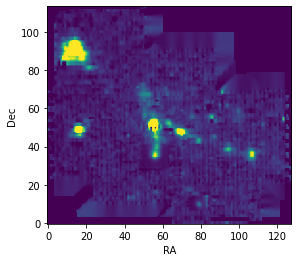

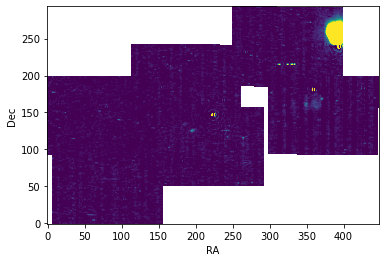

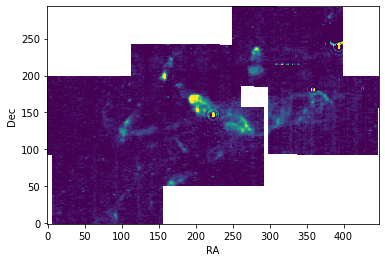

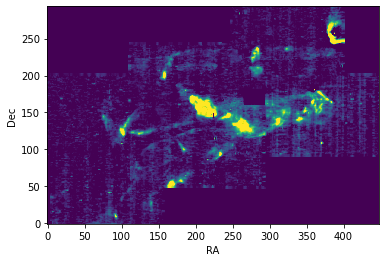

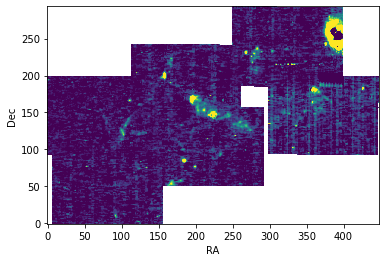

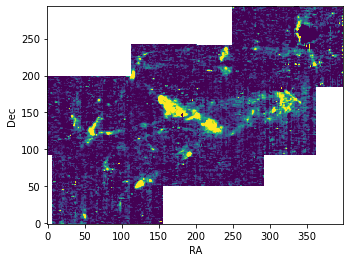

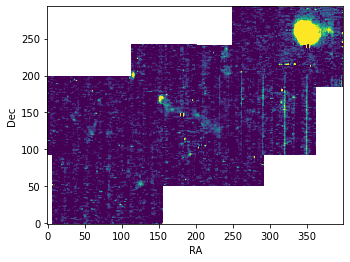

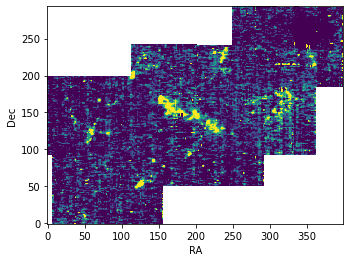

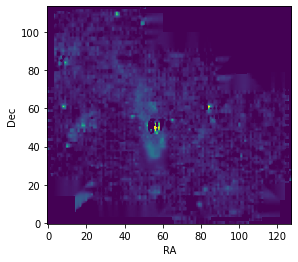

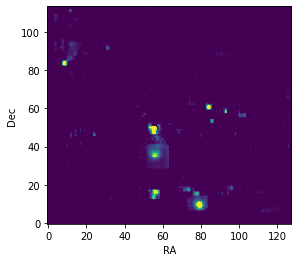

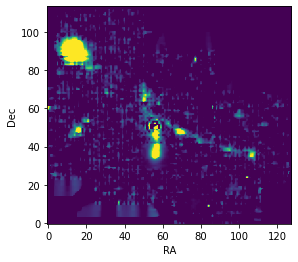

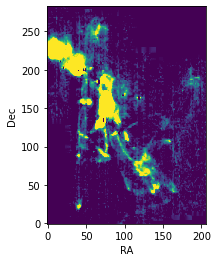

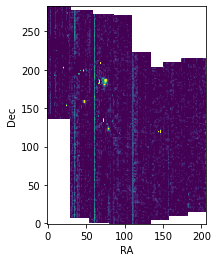

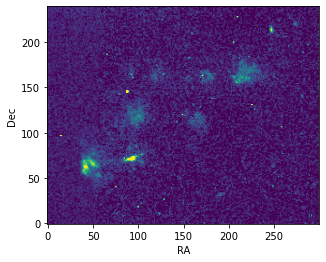

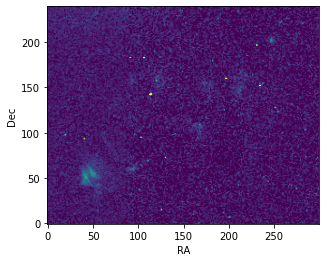

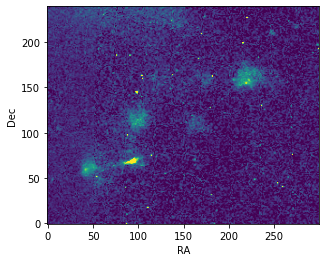

In [14]:

#beginning to loop through and make cououts
data_cutout_list = []
wcs_cutout_list = []
count = 0

#finding a consistent position I know from pixels, converting to skycoords for all images
# position = (4725, 2875)
# position = SkyCoord.from_pixel(position[0], position[1], WCS(hdu_header_list[-1]))

while count < len(hdu_header_list):
    data = hdu_data_list[count]
    w = WCS(hdu_header_list[count])
    
    if count < len(hdu_header_list) - 3:
        position = (20, 50)  #x, y! - in pix space
#         size = (50, 50)  #y, x!...necessary b/c of how cutout works - in pix space
#         position = SkyCoord('3h29m11.3032s +31d18m34.071s', frame='fk5')  #x, y! - in wcs or sky coords
#         size = (50, 50)  #y, x!...necessary b/c of how cutout works - in wcs or sky coords     
#         position = SkyCoord('3h29m12.3032s +31d17m34.071s', frame='fk5')  #x, y! - in wcs or sky coords
        size = (240, 300)  #y, x!...necessary b/c of how cutout works - in wcs or sky coords   
        vmax = 1e-14
        
        datacut = hdu_data_list[count]
        wcscut = w
        
        #     wcs_cutout_list.append(wcs_header_cut)
        wcs_cutout_list.append(hdu_header_list[count])

    else:
        position = (4725, 2875)  #x, y!
#         position = SkyCoord.from_pixel(position[0], position[1], w)
#       size = (240, 300)  #y, x!...necessary b/c of how cutout works
#       position = SkyCoord('3h29m12.3032s +31d18m33.071s', frame='fk5')  #x, y! - in wcs or sky coords
        size = (240, 300)  #y, x!...necessary b/c of how cutout works - in wcs or sky coords   
        vmax = 1e-16

        cutout = Cutout2D(data, position, size, wcs = w)
        datacut = cutout.data
    
        #fixing wcs
        wcscut = cutout.wcs 
        wcs_header_cut = wcscut.to_header()
        print(WCS(wcs_header_cut), WCS(hdu_header_list[count]))
        hdu_header_list[count]['CRPIX1'] = wcs_header_cut['CRPIX1']
        hdu_header_list[count]['CRPIX2'] = wcs_header_cut['CRPIX2']
                
        #     wcs_cutout_list.append(wcs_header_cut)
        wcs_cutout_list.append(hdu_header_list[count])
    
   
    #appending cutouts to list
    data_cutout_list.append(datacut)

    
    #plotting to check
#     implot(data, w, False, vmax)
    implot(datacut, wcscut, False, vmax)  
    
    count += 1    

convolved!
saved convolved images!


C:\Users\Adam2\Anaconda\envs\mypython3\lib\site-packages\matplotlib\colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


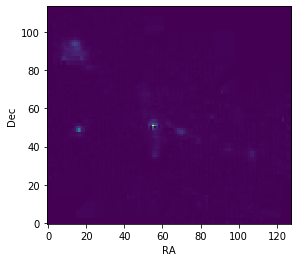

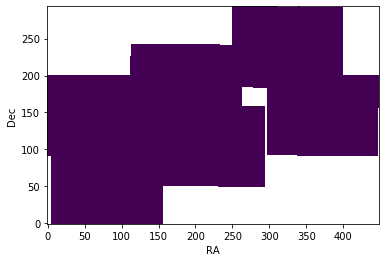

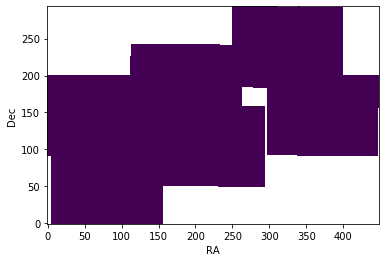

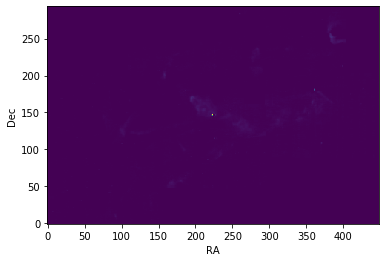

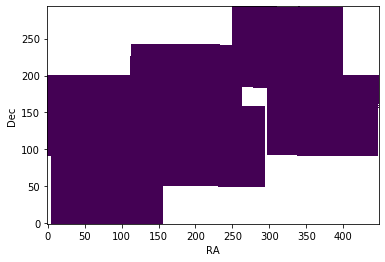

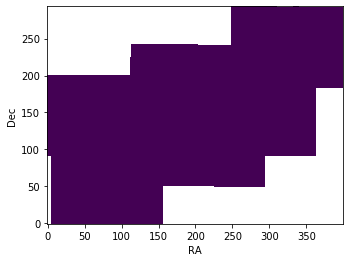

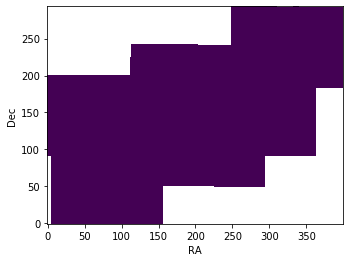

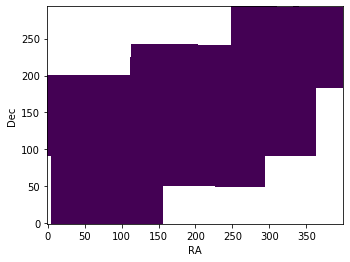

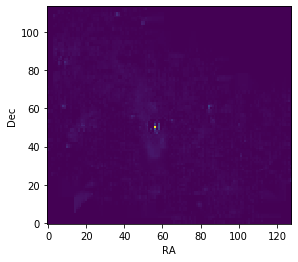

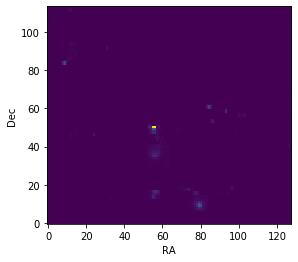

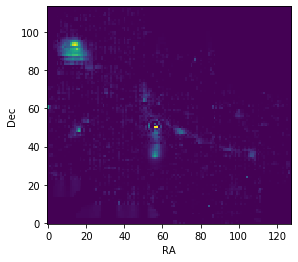

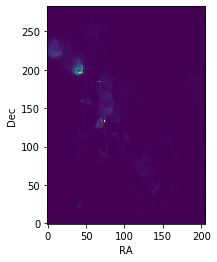

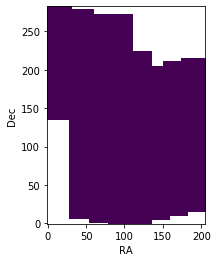

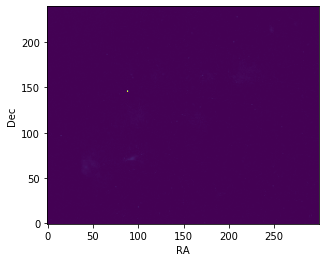

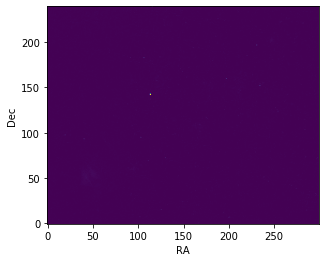

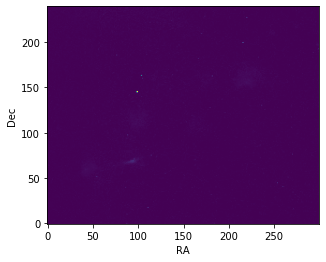

In [5]:
'''
need to do mutual convolutions...it doesn't look like a loop would help much
I really couldn't find a loop, so I just do this mostly by hand...
the basic idea is to run all combinations of convolutions so each image is convolved with each other's psf

here I'm using the function im_conv, which requires the data file name to find the wavelength, the D for the resolution to convolve to, the pixel conversion, and the data that we are convolving
'''
res_str = 'lamflam' #used to label what we're saving, usually related to units or whether we're doing a gaussian or box convolution, etc
hdu_conv_list = [] #what we're trying to fill in
# resize = 60. #if trying to adjust size of gaussian convolution

for conving_count,im_data_conving in enumerate(data_cutout_list): #looping through data which we are convolving, changed to hdu_data_list instead of data_cutout_list
    hdu_im_conv = im_data_conving #storing just in case
    count = 0
    
    if conving_count < len(hdu_list)-3:#spitzer
        D = 85 * 1e4 #cm to microns for spitzer, mic is unit of wavelength file
    
        if files_data[conving_count].find('lh') == True:
            hdu_im_conv = im_conv('n1333_lh_3_SiII_fla', D, hdu_pixtorad_list[count], hdu_im_conv, 'gauss')
        
        elif files_data[conving_count].find('ll') == True:
            hdu_im_conv = im_conv('n1333_ll2_FeII_b', D, hdu_pixtorad_list[count], hdu_im_conv, 'gauss')
        
        #elif files_data[conving_count].fine('sh') == True:
        #hdu_im_conv = im_conv('n1333_sh_1_S32', D, hdu_pixtorad_list[count], hdu_im_conv, 'gauss')
        
        elif files_data[conving_count].find('sl') == True:
            hdu_im_conv = im_conv('n1333_sl1_NeII_', D, hdu_pixtorad_list[count], hdu_im_conv, 'gauss')
        
    elif conving_count > len(hdu_list)-3: #hubble
        D = 2.4 * 1e6 #m to microns for hubble, mic is unit of wavelength file
        hdu_im_conv = im_conv('164_dash', D, hdu_pixtorad_list[count], hdu_im_conv, 'gauss')              
    count += 1

# for conving_count,im_data_conving in enumerate(data_cutout_list): #looping through data which we are convolving
#     hdu_im_conv = im_data_conving #storing just in case
#     count = 0
    
#     for im_psf_source in files_data: #the psf's we are convolving with
# #         #if you want to do every combination possible with overlaps (e.g. im0 with im0,1,2,3... and im1 with im0,1,2,3...)
# #         if count < len(hdu_list)-3:#spitzer
# #             D = 85 * 1e4 #cm to microns for spitzer, mic is unit of wavelength file
# #             hdu_im_conv = im_conv(im_psf_source, D, hdu_pixtorad_list[count], hdu_im_conv, 'gauss')
# #             vmax = 1e-14
            
# #         else: #hubble
# #             D = 2.4 * 1e6 #m to microns for spitzer, mic is unit of wavelength file
# #             hdu_im_conv = im_conv(im_psf_source, D, hdu_pixtorad_list[count], hdu_im_conv, 'gauss')    
# #             vmax = 1e-16

#         #not doing overlaps (e.g. doing hubble ims with all other ones, doing spitzer ones only with self)
#         if conving_count==count and conving_count < len(hdu_list)-3:#spitzer
#             D = 85 * 1e4 #cm to microns for spitzer, mic is unit of wavelength file
#             hdu_im_conv = im_conv(im_psf_source, D, hdu_pixtorad_list[count], hdu_im_conv, 'gauss')

#         elif conving_count==count and conving_count > len(hdu_list)-3: #hubble
#             D = 2.4 * 1e6 #m to microns for spitzer, mic is unit of wavelength file
#             hdu_im_conv = im_conv(im_psf_source, D, hdu_pixtorad_list[count], hdu_im_conv, 'gauss')              
#         count += 1
    
    #plotting to check
    implot(hdu_im_conv, wcs_cutout_list[conving_count], False, np.max(hdu_im_conv))  
    #appending to list for future use
    hdu_conv_list.append(hdu_im_conv)
    
print('convolved!')



'''
onto converting units and then regridding...
'''
#converting the convolved image to correct units and saving it so we can reproject it
#and dividing by the rad^2 to get the image in surface brightness units, to be used in regridding
hdu_conv_scaled_list = []
for count, i in enumerate(hdu_conv_list):
    hdu_conv_scaled_list.append(i / hdu_pixtorad_list[count]**2.)
    

#you'll need to set the WCS to be that of the header you're basing this off of...ie the header
file_start = '../../Convolved_Images_Hub/conv_'+res_str+'_'
conv_path_list = [] #list of paths to the convolved images, can be useful...
#looping through headers and saving images
for count, i in enumerate(wcs_cutout_list):
    #finding wcs for a given image
    #not done in this version since wcs_cutout_list includes headers
#     w = i #WCS(i) if working from original list of headers instead of cutout wcs's
#     wcs_header = w.to_header()

    #saving each file to some path, conv_path is the path to that file
    conv_path = fits_saver(hdu_conv_scaled_list[count], i, files_data[count], file_start)
    conv_path_list.append(conv_path)

print('saved convolved images!')

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 52.24943601055529  31.27148706103002  
CRPIX : 1501.0  1023.0  
CD1_1 CD1_2  : -9.2204215454235e-06  -3.4411110242901e-05  
CD2_1 CD2_2  : -3.4411110242901e-05  9.22042154542351e-06  
NAXIS : 12152  7556
0 ../../Convolved_Images_Hub/conv_lamflam_n1333_lh_3_FeII_flag400_2_map_fixed.FIT
1 ../../Convolved_Images_Hub/conv_lamflam_n1333_sl1_NeII_bksub_trim_2_map.fits
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the ima

14 ../../Convolved_Images_Hub/conv_lamflam_128build_shift_2_drz.fits
15 ../../Convolved_Images_Hub/conv_lamflam_164build_shift_2_drz.fits
saved regridded images!


C:\Users\Adam2\Anaconda\envs\mypython3\lib\site-packages\matplotlib\colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


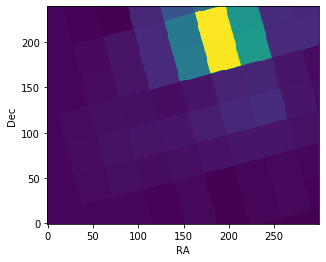

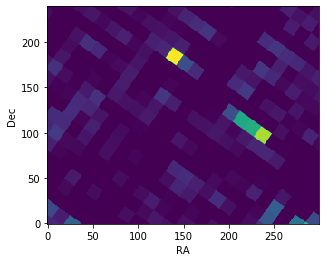

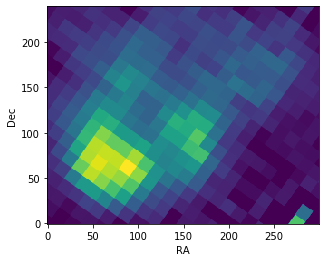

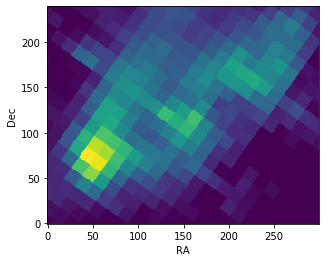

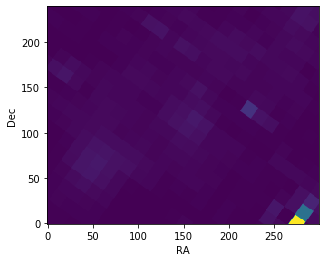

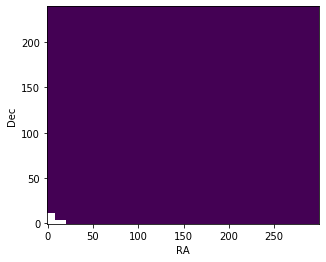

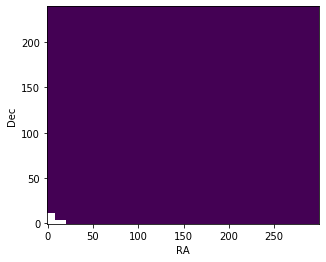

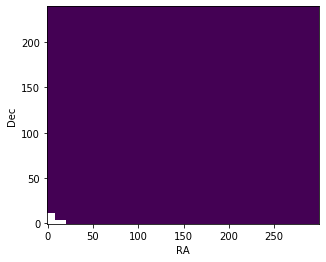

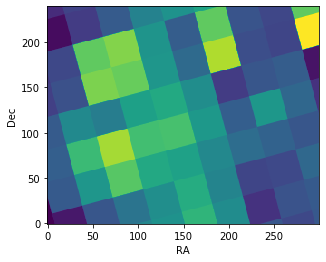

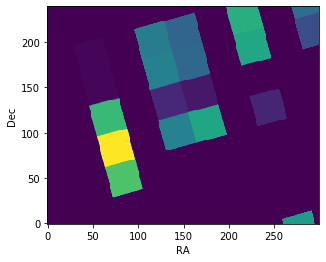

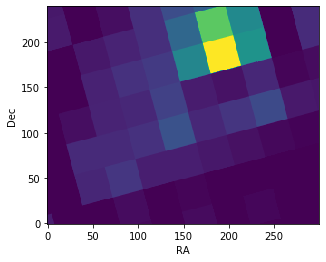

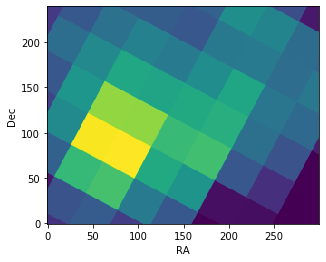

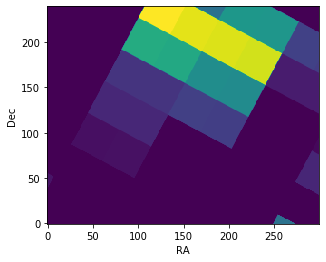

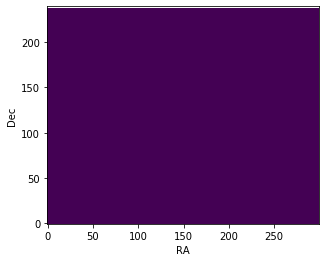

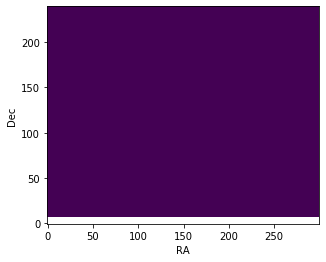

In [6]:
# print(hdu_header_list)
regrid_ind = 15


#an example of reproject by hand here, looping this, makes things more readable!
hdu_regridded_list = []
regrid_path_list = []
regrid_foot_path_list = []

# ##############for regridding just in case...# I put some options below here just in case
file_start = '../../Regridded_Hub/regrid_'+res_str+'_'
para = False   #para is False is for regridding large images (like these hubble ones)

#need a wcs standard for regridding and plots, fits files...
w = WCS(wcs_cutout_list[regrid_ind]) #wcs_cutout_list[regrid_ind] # WCS(hdu_header_list[0]) #I picked 0 arbitrarily, it shouldn't really matter
# wcs_header = w.to_header()
print(w)

#looping through and regridding
for count, i in enumerate(hdu_header_list):
    print(count, conv_path_list[count])
    if count != regrid_ind:        
        #I only put this here in case later someone wants to regrid the images...
        #reprojection of one hdu using the header (coords and pixels) of another
        #The first input is the path to the file we're reprojecting. The second input is the header of the image we're projecting ONTO
        #output is array (a 2D array of data) and footprint (the footprint from the analysis)
        array, footprint = reproject_exact(conv_path_list[count], w, shape_out=hdu_conv_scaled_list[regrid_ind].shape, parallel=para)

        #here's what you'd have to do if you were saving from reproject...
        #first, grabbing the WCS coords of the appropriate image to be set as the header of the new image (set above, always same)
        #then we multiply by the pix^2 to get the right units...
        hdu_regridded_list.append(array * hdu_pixtorad_list[regrid_ind]**2.)
        #plotting to check
        implot(array * hdu_pixtorad_list[regrid_ind]**2., w, False, np.max(array * hdu_pixtorad_list[regrid_ind]**2))  
        
        # remember to have the right header with the wcs below and that it matches the one we're projecting ONTO
        regrid_path = fits_saver(hdu_regridded_list[count], wcs_cutout_list[regrid_ind], files_data[count], file_start) #* hdu_pixtorad_list[count]**2., wcs_header, files_data[count], file_start)
        regrid_path_list.append(regrid_path)
        
        #same for footprints
        regrid_foot_path = fits_saver(footprint * hdu_pixtorad_list[regrid_ind]**2., wcs_cutout_list[regrid_ind], files_data[count], file_start+'footprint_')
        regrid_foot_path_list.append(regrid_foot_path)

    else:
        hdu_regridded_list.append(hdu_conv_scaled_list[regrid_ind] * hdu_pixtorad_list[regrid_ind]**2)
        regrid_path = fits_saver(hdu_regridded_list[regrid_ind], hdu_header_list[regrid_ind], files_data[regrid_ind], file_start)


print('saved regridded images!')

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 52.24943601055529  31.27148706103002  
CRPIX : 1501.0  1023.0  
CD1_1 CD1_2  : -9.2204215454235e-06  -3.4411110242901e-05  
CD2_1 CD2_2  : -3.4411110242901e-05  9.22042154542351e-06  
NAXIS : 12152  7556
Rv you should get is 5.5, you get:  5.545004128819156
For example, HAlpha:  [[15.14052816  9.419369           nan ... 29.27235241 11.86117976
  22.10656849]
 [ 9.42247078 14.86894913         nan ...         nan         nan
          nan]
 [ 6.37426444 20.10118801         nan ...         nan 12.56089212
  22.94388989]
 ...
 [11.95643425  5.94089672         nan ...         nan  4.12441786
  18.0800257 ]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]]


IndexError: list index out of range

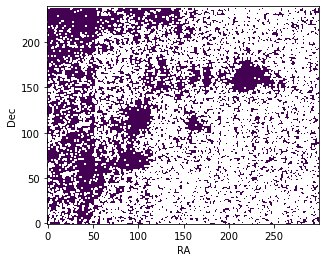

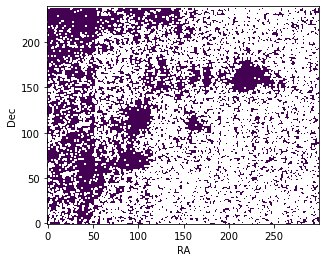

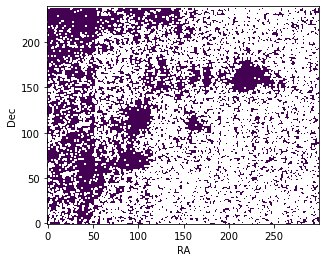

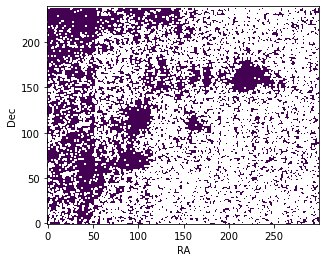

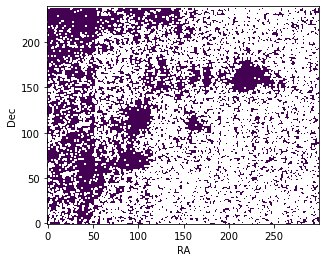

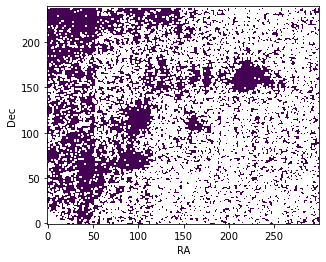

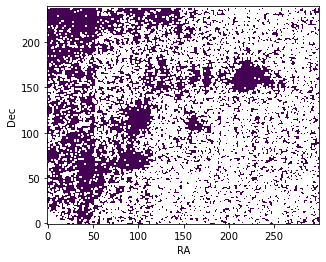

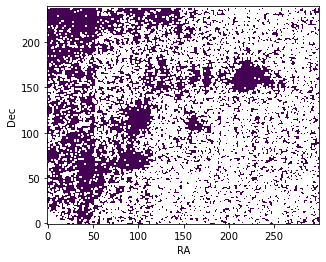

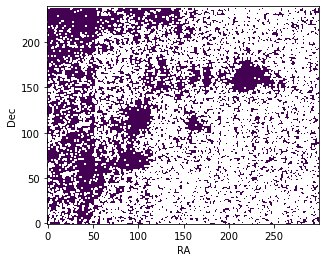

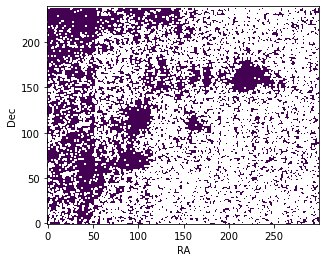

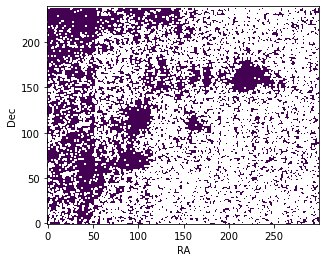

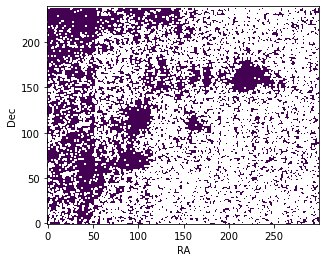

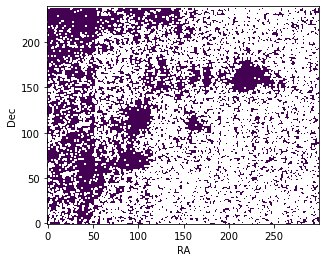

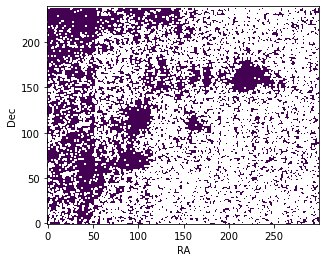

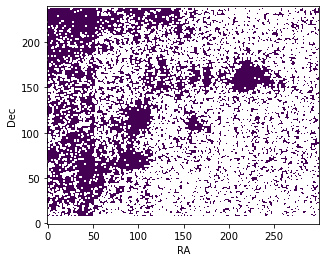

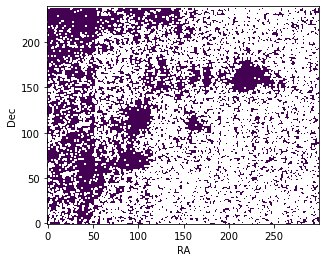

In [20]:
from scipy.interpolate import CubicSpline
res_str = 'lamflam'

# print(hdu_header_list)
regrid_ind = 15
#need a wcs standard for regridding and plots, fits files...
w = WCS(wcs_cutout_list[regrid_ind]) #wcs_cutout_list[regrid_ind] # WCS(hdu_header_list[0]) #I picked 0 arbitrarily, it shouldn't really matter
# wcs_header = w.to_header()
print(w)


#for de-extincting...should do at an earlier stage for the other lines or just not delete them....
#extracting data
kext_dat = np.genfromtxt('kext_albedo_WD_MW_5.5A_30_D03_delimmod.txt', delimiter=' ', dtype=None, skip_header=80, usecols=range(0,5)) #reading in excel file of extinctions
kext_dat_ascend = sorted(kext_dat, key=lambda x:x[0]) #sorted in ascending order, from small to large lambda

#extracting relevant data and interpolating
lam_kext = [i[0] for i in kext_dat_ascend]
Cext_kext = [i[3] for i in kext_dat_ascend]
vs = CubicSpline(lam_kext, Cext_kext) #interpolating

#checking values
lambdaV = 0.547
lambdaB = 0.4405
print('Rv you should get is 5.5, you get: ', vs(lambdaV) / (vs(lambdaB) - vs(lambdaV))) #checks Rv value


#next part, applying formula we require, which is optical depth as function of lambda, iron 2 ratio
lam_chosen = 0.656 #lambda should be in microns, this is a test
C_ext_Fe2const = vs(1.26) - vs(1.64) #constant used in formula
s0 = 2.6 #1.26 to 1.64 ratio from EDFs


# allowing us to go through without rerunning the conv/regrid stuff
# read in the final regridded images excluding the footprints
placeholderList = glob.glob("../../Regridded_Hub/*_lamflam_*")
placeholderList[:] = [x for x in placeholderList if x.find('footprint')==-1]

# reordering the placeholder list to match lam_list and files_units
FUSplitList =[]
for i in range(len(files_units)):
    FileUSplit = files_units[i].split('/')
    FUSplitList.append(FileUSplit[-1])

reorderedList = []
for i in FUSplitList:
    for j in range(len(placeholderList)):
        if i in placeholderList[j]:
            reorderedList.append(placeholderList[j])
        else:
            continue
reorderedList.append(placeholderList[0])
reorderedList.append(placeholderList[1])
reorderedList.append(placeholderList[2])

hdu_regridRecovered_list = []
for i in reorderedList:
    hdu_regridRecovered_list.append(fits.open(i)[0].data)


    #now computing ratio from our images...
s = hdu_regridRecovered_list[-3] / hdu_regridRecovered_list[-1] #chosen ratio, 1.26 / 1.64
s[s>s0]=np.nan #above our chosen ratio, we ignore because would result in negative extinction ?
s[s<=0.01]=np.nan #AMANDA UPDATE: adjusting range

'''NEED TO UPDATE THESE NOISES!!! I THINK THIS IS USED AS THE NOISE CUTOFF......
noises = [3.06806e-19, 1.12685e-18, 2.20903e-18, 1.98002e-18, 2.91648e-18, 5.0651e-18, 5.18521e-18, 
          7.62499e-18, 4.04933e-19, 4.79245e-19, 6.88845e-19, 4.24433e-19, 5.57392e-19, 2.04831e-18, 
          1.0422043e-18, 3.64545e-18] #noises need to be specific for each image, hardcoding them in by taking error from small region in regridded images, error too big trying stddev?

# for i in range(len(hdu_regridRecovered_list)):
#     file = hdu_regridRecovered_list[i]
#     print(file[file<=1*noises[i]])
#     file[file<=1*noises[i]]= np.nan
    #print(file[file<=1*noises[i]])
'''
noises = [3.06806e-19, 1.12685e-18, 2.20903e-18, 1.98002e-18, 2.91648e-18, 5.0651e-18, 5.18521e-18, 
          7.62499e-18, 4.04933e-19, 4.79245e-19, 6.88845e-19, 4.24433e-19, 5.57392e-19, 2.04831e-18, 
          1.0422043e-18, 3.64545e-18] #noises need to be specific for each image, hardcoding them in by taking error from small region in regridded images, error too big trying stddev?

for i in range(len(hdu_regridRecovered_list)):
    file = hdu_regridRecovered_list[i]
    print(file[file<=1*noises[i]])
    file[file<=1*noises[i]]= np.nan
    print(file[file<=1*noises[i]])

tau_ext = vs(lam_chosen) / C_ext_Fe2const * np.log(s0 / s) #applying formula
print('For example, HAlpha: ', tau_ext)

#now we need wavelengths to get this function fully working...it is a func of wavelength after all...
#unfortunately, our images are awkwardly ordered not by wavelength so...need something to match/extract it
df = pd.read_excel('imglams.xlsx')
cols = df.columns
cols_str = [str(i) for i in df[cols[0]]]

lam_list = []
for name in files_units:
    #this finds the loc in the excel file where the image substring matches our image name
    #it then finds the wavelength value corresponding to that loc
    lam =  df.loc[np.where([i in name for i in cols_str])[0][0]].values[1] #lambda in microns
    lam_list.append(lam)

    
#computing tau for each image, then taking image * exp(tau) and saving
file_start = '../../Deextincted/deext_'+res_str+'_'
hdu_deextincted_list = []
for n in range(len(hdu_regridRecovered_list)):
    tau_ext = vs(lam_list[n]) / C_ext_Fe2const * np.log(s0 / s) #applying formula  
    hdu_deextinc = hdu_regridRecovered_list[n] * np.exp(tau_ext)
    implot(hdu_deextinc, w, False, np.max(hdu_deextinc))  
    regrid_path = fits_saver(hdu_deextinc, wcs_cutout_list[regrid_ind], files_data[n], file_start) #* hdu_pixtorad_list[count]**2., wcs_header, files_data[count], file_start)
    hdu_deextincted_list.append(hdu_deextinc)


In [18]:
data126 = hdu_deextinc

for y,x in itertools.product(range(data126.shape[0]),range(data126.shape[1])):
    pixel = data126[y,x]
    
    if (y+1 == 240) or (x+1 == 300): # this number falls out of range for the array so just picking different neighbors       
        n1 = data126[y-1,x]
        n2 = data126[y,x-1]
        n3 = data126[y-1,x-1]
        if (pixel == np.nan) and (n1 == np.nan) and (n2 == np.nan) and (n3 == np.nan): #np.nanmean/median doesn't seem to like all nans
            continue
        else:
            navg = np.nanmedian([n1,n2,n3]) # taking the median of the 3 nearest neighbors
            if pixel > 10**(7)*navg: # if the pixel is 10^7 times brighter than median its set to median, could change cutoff
                data126[y,x] = navg
            else:
                continue
    
    elif (y-1 == -1) or (x-1 == -1): # this would send it to the other end of the image so not actually near the pixel
        n1 = data126[y+1,x]
        n2 = data126[y,x+1]
        n3 = data126[y+1, x+1]
        if (pixel == np.nan) and (n1 == np.nan) and (n2 == np.nan) and (n3 == np.nan):
            continue
        else:
            navg = np.nanmedian([n1,n2,n3])
            if pixel > 10**(7)*navg:
                data126[y,x] = navg
            else:
                continue
    
    else:
        n1 = data126[y-1,x]
        n2 = data126[y,x-1]
        n3 = data126[y+1,x]
        n4 = data126[y,x+1]
        if (pixel == np.nan) and (n1 == np.nan) and (n2 == np.nan) and (n3 == np.nan) and (n4 == np.nan):
            continue
        else:
            navg = np.nanmedian([n1,n2,n3,n4])
            if pixel > 10**(7)*navg:
                data126[y,x] = navg
            else:
                continue
    
hst126.writeto("BrightPixelTest16.fits")


NameError: name 'hst126' is not defined

In [23]:
# regrid_path = fits_saver(data126, wcs_cutout_list[regrid_ind], files_data[n], 'BrightPixelTest16_') #* hdu_pixtorad_list[count]**2., wcs_header, files_data[count], file_start)
'''
we would like to compare the sum of 1.13968e-14 from the processed image
to the sum of 58.8541 from the unprocessed dash mode image
'''
# print(58.8541 * hdu_units[0].header['PHOTFLAM'] * hdu_units[0].header['PHOTBW'])
print(58.8541 * 2.7760207E-19 * 700.0654299999999)

#of note: the same region in the dereddened image, with the pixel filter added by amanda gets 4.8171e-14
#without the pixel filter, I still got 4.8171e-14 for the exact same region (therefore no effect)

1.1437682988238712e-14


In [35]:
#purpose of this cell is to deal with apertures
#for hh6, refer to http://articles.adsabs.harvard.edu/pdf/1991ApJ...371..237C for aperture examples (fig. 5)

#possibly could do EDFs, possibly dividing the hubble images to determine extinction...maybe should do separately?
#if you want to divide two of the data files, can do so like
#data_ratio = np.divide(array, hdu1_conv_scaled, out=np.zeros_like(array), where=hdu1_conv_scaled!=0) #need to do np.divide to guarantee we get no divide by zero issue...

#knots 1 ... 7
coords_list = [[(50., 65.), (40, 40)], 
              [(97, 75), (40, 40)],
              [(100, 119), (47, 47)],
              [(120, 155), (43, 65)],
              [(167, 115), (44, 44)],
              [(175, 163), (40, 40)],
              [(220, 167), (52, 52)],
              ]

#setting up a pandas table to be saved as excel (will store fluxes for the fitting code)
#pandas used because easy to sort and save
column_names = ['Lines', 'Lambda'] #columns
for num in range(len(coords_list)):
    column_names.append('Knot'+str(num))

#matching wavelengths and lines we have...will work as row names
df = pd.read_excel('imglams.xlsx')
cols = df.columns
cols_str = [str(i) for i in df[cols[0]]]

lam_list = []
line_list = []
for name in files_units:
    #this finds the loc in the excel file where the image substring matches our image name
    #it then finds the wavelength value corresponding to that loc
    line =  df.loc[np.where([i in name for i in cols_str])[0][0]].values[0] #lambda in microns
    lam =  df.loc[np.where([i in name for i in cols_str])[0][0]].values[1] #lambda in microns
    
    #this is just to clean up the strings before appending
    if name.find('n1333_') != -1:
        line_list.append(line.split('n1333_')[-1])
    else:
        line_list.append(line)
    lam_list.append(lam)

#creating dataframe and filling in the first two columns from the lists we just made
df = pd.DataFrame(columns = column_names)
df['Lines'] = line_list
df['Lambda'] = lam_list


#looping through images (wavelengths)
for i in range(len(hdu_deextincted_list)):
    #looping through knots
    for j in range(len(coords_list)):
        #unpacking coords
        position = coords_list[j][0]
        size = coords_list[j][1]
        
        #cutting out coordinates    
        cutout = Cutout2D(hdu_deextincted_list[i], position, size, wcs = w)
        datacut = cutout.data
        wcscut = cutout.wcs
        
        knot_flux = np.nansum(datacut) #computing the flux of the cutout for each knot
        #saving fluxes in a table
        df['Knot'+str(j)].at[i] = knot_flux
        
        
#         #plotting image
#         implot(datacut, wcscut, False, max(datacut))

# print(df.sort_values(by=['Lambda'], ascending=True)) #if you want to sort by wavelength from low to high lambdas
print(df)

#saving as excel file for use in next code
excel_savepath = '../../../../Model Code and Observations/HH6_Adam/Dered_FluxesFinal.xlsx'
# !conda install --yes --prefix {sys.prefix} openpyxl #IF FIRST TIME DOING THIS/don't have package - takes multiple minutes
df.to_excel(excel_savepath, index=False)
print('saved data!')

            Lines    Lambda        Knot0        Knot1        Knot2  \
0      lh_3_FeII_  26.00000  2.80282e-15  3.63524e-15  4.86549e-15   
1       sl1_NeII_  12.81200 -2.24757e-15 -1.49295e-15  7.77924e-16   
2        sl1_S2_b  12.27900  6.61349e-14  6.63471e-14  4.85961e-14   
3        sl1_S3_b   9.66500  1.44638e-13  1.29483e-13  1.49953e-13   
4        sl1_S4_b   8.02500  7.02322e-14  4.39839e-14  3.43051e-14   
5        sl2_S5_b   6.91000  1.34921e-13  7.32668e-14  9.04923e-14   
6        sl2_S6_b   6.10900  4.65196e-14  2.28653e-14  3.58221e-14   
7        sl2_S7_b   5.51100  1.31427e-13  7.24498e-14   7.7525e-14   
8       lh_3_S0_f  28.21900  2.87565e-15    3.305e-15  3.73996e-15   
9      lh_3_SI_fl  25.24900 -6.12013e-16  5.86556e-16 -1.36047e-15   
10  lh_3_SiII_fla  34.81400  4.15878e-15  4.59053e-15  6.23501e-15   
11      ll2_S1_bk  17.03500  2.23798e-14  2.86894e-14  3.52259e-14   
12     ll2_FeII_b  17.93600  -4.1516e-16  3.88522e-16  1.91576e-15   
13            126   

In [ ]:
#now model iron II lines! 26, 126, 164, 17.9